In [2]:
## Immports
import sys
import os
from collections import deque

import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
sys.path.append('../')

from data_process.ttnet_video_loader import TTNet_Video_Loader
from models.model_utils import create_model, load_pretrained_model
from config.config import parse_configs
from utils.post_processing import post_processing
from utils.misc import time_synchronized
import os
import cv2
import sys
import time
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
# ls ../../checkpoints/ttnet/

In [3]:
configs = parse_configs()

In [4]:
configs.video_path           = "/home/stupa/Desktop/Rahul/Research/TTnet/dataset/training/videos/game_1.mp4"
configs.save_demo_output     = True
configs.pretrained_path      = "../../checkpoints/ttnet/ttnet_1st_phase_ori_epoch_30.pth"
configs.seg_thresh           = 0.5 
configs.event_thresh         = 0.5 
configs.thresh_ball_pos_mask = 0.05 
configs.saved_fn             = 'demo' 
configs.arch                 = 'ttnet' 
configs.save_demo_dir        = "../../results/analysis/1st/"
configs.gpu_idx              = 0

In [5]:
video_loader = TTNet_Video_Loader(configs.video_path, configs.input_size, configs.num_frames_sequence)
frame_rate = video_loader.video_fps
if configs.save_demo_output:
    configs.frame_dir = os.path.join(configs.save_demo_dir, 'frame')
    if not os.path.isdir(configs.frame_dir):
        os.makedirs(configs.frame_dir)
        
configs.device = torch.device('cuda:{}'.format(configs.gpu_idx))

# model
# model = create_model(configs)
# model.cuda()

# assert configs.pretrained_path is not None, "Need to load the pre-trained model"
# model = load_pretrained_model(model, configs.pretrained_path, configs.gpu_idx, configs.overwrite_global_2_local)

# model.eval()
middle_idx = int(configs.num_frames_sequence / 2)
queue_frames = deque(maxlen=middle_idx + 1)
frame_idx = 0
w_original, h_original = 1920, 1080
w_resize, h_resize = 320, 128
w_ratio = w_original / w_resize
h_ratio = h_original / h_resize

Length of the video: 88599 frames


In [6]:
for count, resized_imgs in video_loader:
    break

In [7]:
def plot_from_buffer(buffer, index=0):
    aa = np.transpose(buffer, (1,2,0))
    aa = aa[:,:,index:index+3]
    return plt.imshow(aa)

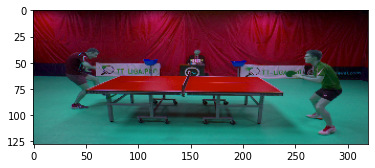

In [8]:
plot_from_buffer(resized_imgs, 5)

In [ ]:
img = cv2.resize(resized_imgs[3 * middle_idx: 3 * (middle_idx + 1)].transpose(1, 2, 0), (w_original, h_original))
# Expand the first dim
resized_imgs = torch.from_numpy(resized_imgs).to(configs.device, non_blocking=True).float().unsqueeze(0)

In [17]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        x = self.maxpool(self.relu(self.batchnorm(self.conv(x))))
        return x
class ConvBlock_without_Pooling(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock_without_Pooling, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.batchnorm(self.conv(x)))
        return x
class DeconvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DeconvBlock, self).__init__()
        middle_channels = int(in_channels / 4)
        self.conv1 = nn.Conv2d(in_channels, middle_channels, kernel_size=1, stride=1, padding=0)
        self.batchnorm1 = nn.BatchNorm2d(middle_channels)
        self.relu = nn.ReLU()
        self.batchnorm_tconv = nn.BatchNorm2d(middle_channels)
        self.tconv = nn.ConvTranspose2d(middle_channels, middle_channels, kernel_size=3, stride=2, padding=1,
                                        output_padding=1)
        self.conv2 = nn.Conv2d(middle_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batchnorm2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.relu(self.batchnorm1(self.conv1(x)))
        x = self.relu(self.batchnorm_tconv(self.tconv(x)))
        x = self.relu(self.batchnorm2(self.conv2(x)))

        return x
class BallDetection(nn.Module):
    def __init__(self, num_frames_sequence, dropout_p):
        super(BallDetection, self).__init__()
        self.conv1 = nn.Conv2d(num_frames_sequence * 3, 64, kernel_size=1, stride=1, padding=0)
        self.batchnorm = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.convblock1 = ConvBlock(in_channels=64, out_channels=64)
        self.convblock2 = ConvBlock(in_channels=64, out_channels=64)
        self.dropout2d = nn.Dropout2d(p=dropout_p)
        self.convblock3 = ConvBlock(in_channels=64, out_channels=128)
        self.convblock4 = ConvBlock(in_channels=128, out_channels=128)
        self.convblock5 = ConvBlock(in_channels=128, out_channels=256)
        self.convblock6 = ConvBlock(in_channels=256, out_channels=256)
        self.fc1 = nn.Linear(in_features=2560, out_features=1792)
        self.fc2 = nn.Linear(in_features=1792, out_features=896)
        self.fc3 = nn.Linear(in_features=896, out_features=448)
        self.dropout1d = nn.Dropout(p=dropout_p)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.batchnorm(self.conv1(x)))
        out_block2 = self.convblock2(self.convblock1(x))
        x = self.dropout2d(out_block2)
        out_block3 = self.convblock3(x)
        out_block4 = self.convblock4(out_block3)
        x = self.dropout2d(out_block4)
        out_block5 = self.convblock5(out_block4)
        features = self.convblock6(out_block5)

        x = self.dropout2d(features)
        x = x.contiguous().view(x.size(0), -1)

        x = self.dropout1d(self.relu(self.fc1(x)))
        x = self.dropout1d(self.relu(self.fc2(x)))
        out = self.sigmoid(self.fc3(x))

        return out, features, out_block2, out_block3, out_block4, out_block5
class EventsSpotting(nn.Module):
    def __init__(self, dropout_p):
        super(EventsSpotting, self).__init__()
        self.conv1 = nn.Conv2d(512, 64, kernel_size=1, stride=1, padding=0)
        self.batchnorm = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.dropout2d = nn.Dropout2d(p=dropout_p)
        self.convblock = ConvBlock_without_Pooling(in_channels=64, out_channels=64)
        self.fc1 = nn.Linear(in_features=640, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, global_features, local_features):
        input_eventspotting = torch.cat((global_features, local_features), dim=1)
        x = self.relu(self.batchnorm(self.conv1(input_eventspotting)))
        x = self.dropout2d(x)
        x = self.convblock(x)
        x = self.dropout2d(x)
        x = self.convblock(x)
        x = self.dropout2d(x)

        x = x.contiguous().view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        out = self.sigmoid(self.fc2(x))

        return out
class Segmentation(nn.Module):
    def __init__(self):
        super(Segmentation, self).__init__()
        self.deconvblock5 = DeconvBlock(in_channels=256, out_channels=128)
        self.deconvblock4 = DeconvBlock(in_channels=128, out_channels=128)
        self.deconvblock3 = DeconvBlock(in_channels=128, out_channels=64)
        self.deconvblock2 = DeconvBlock(in_channels=64, out_channels=64)
        self.tconv = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=0,
                                        output_padding=0)
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(32, 3, kernel_size=2, stride=1, padding=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, out_block2, out_block3, out_block4, out_block5):
        x = self.deconvblock5(out_block5)
        x = x + out_block4
        x = self.deconvblock4(x)
        x = x + out_block3
        x = self.deconvblock3(x)

        x = x + out_block2
        x = self.deconvblock2(x)

        x = self.relu(self.tconv(x))

        x = self.relu(self.conv1(x))

        out = self.sigmoid(self.conv2(x))

        return out
class TTNet(nn.Module):
    def __init__(self, dropout_p, tasks, input_size, thresh_ball_pos_mask, num_frames_sequence,
                 mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
        super(TTNet, self).__init__()
        self.tasks = tasks
        self.ball_local_stage, self.events_spotting, self.segmentation = None, None, None
        self.ball_global_stage = BallDetection(num_frames_sequence=num_frames_sequence, dropout_p=dropout_p)
        if 'local' in tasks:
            self.ball_local_stage = BallDetection(num_frames_sequence=num_frames_sequence, dropout_p=dropout_p)
        if 'event' in tasks:
            self.events_spotting = EventsSpotting(dropout_p=dropout_p)
        if 'seg' in tasks:
            self.segmentation = Segmentation()
        self.w_resize = input_size[0]
        self.h_resize = input_size[1]
        self.thresh_ball_pos_mask = thresh_ball_pos_mask
        self.mean = torch.repeat_interleave(torch.tensor(mean).view(1, 3, 1, 1), repeats=9, dim=1)
        self.std = torch.repeat_interleave(torch.tensor(std).view(1, 3, 1, 1), repeats=9, dim=1)

    def forward(self, resize_batch_input, org_ball_pos_xy):
        """Forward propagation
        :param resize_batch_input: (batch_size, 27, 128, 320)
        :param org_ball_pos_xy: (batch_size, 2) --> Use it to get ground-truth for the local stage
        :return:
        """
        pred_ball_local, pred_events, pred_seg, local_ball_pos_xy = None, None, None, None

        # Normalize the input before compute forward propagation
        pred_ball_global, global_features, out_block2, out_block3, out_block4, out_block5 = self.ball_global_stage(
            self.__normalize__(resize_batch_input))
        if self.ball_local_stage is not None:
            # Based on the prediction of the global stage, crop the original images
            input_ball_local, cropped_params = self.__crop_original_batch__(resize_batch_input, pred_ball_global)
            # Get the ground truth of the ball for the local stage
            local_ball_pos_xy = self.__get_groundtruth_local_ball_pos__(org_ball_pos_xy, cropped_params)
            # Normalize the input before compute forward propagation
            pred_ball_local, local_features, *_ = self.ball_local_stage(self.__normalize__(input_ball_local))
            # Only consider the events spotting if the model has the local stage for ball detection
            if self.events_spotting is not None:
                pred_events = self.events_spotting(global_features, local_features)
        if self.segmentation is not None:
            pred_seg = self.segmentation(out_block2, out_block3, out_block4, out_block5)

        return pred_ball_global, pred_ball_local, pred_events, pred_seg, local_ball_pos_xy

    def run_demo(self, resize_batch_input):
        """Only for full 4 stages/modules in TTNet"""

        # Normalize the input before compute forward propagation
        pred_ball_global, global_features, out_block2, out_block3, out_block4, out_block5 = self.ball_global_stage(
            self.__normalize__(resize_batch_input))
        input_ball_local, cropped_params = self.__crop_original_batch__(resize_batch_input, pred_ball_global)
        # Normalize the input before compute forward propagation
        pred_ball_local, local_features, *_ = self.ball_local_stage(self.__normalize__(input_ball_local))
        pred_events = self.events_spotting(global_features, local_features)
        pred_seg = self.segmentation(out_block2, out_block3, out_block4, out_block5)

        return pred_ball_global, pred_ball_local, pred_events, pred_seg

    def __normalize__(self, x):
        if not self.mean.is_cuda:
            self.mean = self.mean.cuda()
            self.std = self.std.cuda()

        return (x / 255. - self.mean) / self.std

    def __get_groundtruth_local_ball_pos__(self, org_ball_pos_xy, cropped_params):
        local_ball_pos_xy = torch.zeros_like(org_ball_pos_xy)  # no grad for torch.zeros_like output

        for idx, params in enumerate(cropped_params):
            is_ball_detected, x_min, x_max, y_min, y_max, x_pad, y_pad = params

            if is_ball_detected:
                # Get the local ball position based on the crop image informaion
                local_ball_pos_xy[idx, 0] = max(org_ball_pos_xy[idx, 0] - x_min + x_pad, -1)
                local_ball_pos_xy[idx, 1] = max(org_ball_pos_xy[idx, 1] - y_min + y_pad, -1)
                # If the ball is outside of the cropped image --> set position to -1, -1 --> No ball
                if (local_ball_pos_xy[idx, 0] >= self.w_resize) or (local_ball_pos_xy[idx, 1] >= self.h_resize) or (
                        local_ball_pos_xy[idx, 0] < 0) or (local_ball_pos_xy[idx, 1] < 0):
                    local_ball_pos_xy[idx, 0] = -1
                    local_ball_pos_xy[idx, 1] = -1
            else:
                local_ball_pos_xy[idx, 0] = -1
                local_ball_pos_xy[idx, 1] = -1
        return local_ball_pos_xy

    def __crop_original_batch__(self, resize_batch_input, pred_ball_global):
        """Get input of the local stage by cropping the original images based on the predicted ball position
            of the global stage
        :param resize_batch_input: (batch_size, 27, 128, 320)
        :param pred_ball_global: (batch_size, 448)
        :param org_ball_pos_xy: (batch_size, 2)
        :return: input_ball_local (batch_size, 27, 128, 320)
        """
        # Process input for local stage based on output of the global one

        batch_size = resize_batch_input.size(0)
        h_original, w_original = 1080, 1920
        h_ratio = h_original / self.h_resize
        w_ratio = w_original / self.w_resize
        pred_ball_global_mask = pred_ball_global.clone().detach()
        pred_ball_global_mask[pred_ball_global_mask < self.thresh_ball_pos_mask] = 0.

        # Crop the original images
        input_ball_local = torch.zeros_like(resize_batch_input)  # same shape with resize_batch_input, no grad
        original_batch_input = F.interpolate(resize_batch_input, (h_original, w_original))  # On GPU
        cropped_params = []
        for idx in range(batch_size):
            pred_ball_pos_x = pred_ball_global_mask[idx, :self.w_resize]
            pred_ball_pos_y = pred_ball_global_mask[idx, self.w_resize:]
            # If the ball is not detected, we crop the center of the images, set ball_poss to [-1, -1]
            if (torch.sum(pred_ball_pos_x) == 0.) or (torch.sum(pred_ball_pos_y) == 0.):
                # Assume the ball is in the center image
                x_center = int(self.w_resize / 2)
                y_center = int(self.h_resize / 2)
                is_ball_detected = False
            else:
                x_center = torch.argmax(pred_ball_pos_x)  # Upper part
                y_center = torch.argmax(pred_ball_pos_y)  # Lower part
                is_ball_detected = True

            # Adjust ball position to the original size
            x_center = int(x_center * w_ratio)
            y_center = int(y_center * h_ratio)

            x_min, x_max, y_min, y_max = self.__get_crop_params__(x_center, y_center, self.w_resize, self.h_resize,
                                                                  w_original, h_original)
            # Put image to the center
            h_crop = y_max - y_min
            w_crop = x_max - x_min
            x_pad = 0
            y_pad = 0
            if (h_crop != self.h_resize) or (w_crop != self.w_resize):
                x_pad = int((self.w_resize - w_crop) / 2)
                y_pad = int((self.h_resize - h_crop) / 2)
                input_ball_local[idx, :, y_pad:(y_pad + h_crop), x_pad:(x_pad + w_crop)] = original_batch_input[idx, :,
                                                                                           y_min:y_max, x_min: x_max]
            else:
                input_ball_local[idx, :, :, :] = original_batch_input[idx, :, y_min:y_max, x_min: x_max]
            cropped_params.append([is_ball_detected, x_min, x_max, y_min, y_max, x_pad, y_pad])

        return input_ball_local, cropped_params

    def __get_crop_params__(self, x_center, y_center, w_resize, h_resize, w_original, h_original):
        x_min = max(0, x_center - int(w_resize / 2))
        y_min = max(0, y_center - int(h_resize / 2))

        x_max = min(w_original, x_min + w_resize)
        y_max = min(h_original, y_min + h_resize)

        return x_min, x_max, y_min, y_max

In [39]:
tasks = ['global', 'local', 'event']
ttnet = TTNet(dropout_p=0.5, tasks=tasks, input_size=(320, 128), thresh_ball_pos_mask=0.01,
                  num_frames_sequence=9).cuda()

In [40]:
trained = torch.load(configs.pretrained_path)

In [41]:
new_trained = {}
for key in list(trained['state_dict'].keys()):
    new_trained[key[6:]] = trained['state_dict'][key]

In [42]:
ttnet.state_dict().keys()

odict_keys(['ball_global_stage.conv1.weight', 'ball_global_stage.conv1.bias', 'ball_global_stage.batchnorm.weight', 'ball_global_stage.batchnorm.bias', 'ball_global_stage.batchnorm.running_mean', 'ball_global_stage.batchnorm.running_var', 'ball_global_stage.batchnorm.num_batches_tracked', 'ball_global_stage.convblock1.conv.weight', 'ball_global_stage.convblock1.conv.bias', 'ball_global_stage.convblock1.batchnorm.weight', 'ball_global_stage.convblock1.batchnorm.bias', 'ball_global_stage.convblock1.batchnorm.running_mean', 'ball_global_stage.convblock1.batchnorm.running_var', 'ball_global_stage.convblock1.batchnorm.num_batches_tracked', 'ball_global_stage.convblock2.conv.weight', 'ball_global_stage.convblock2.conv.bias', 'ball_global_stage.convblock2.batchnorm.weight', 'ball_global_stage.convblock2.batchnorm.bias', 'ball_global_stage.convblock2.batchnorm.running_mean', 'ball_global_stage.convblock2.batchnorm.running_var', 'ball_global_stage.convblock2.batchnorm.num_batches_tracked', 'bal

In [43]:
ttnet.load_state_dict(new_trained)

<All keys matched successfully>

In [ ]:
# model.

In [ ]:
pred_ball_global, pred_ball_local, pred_events, pred_seg = model.run_demo(resized_imgs)

In [ ]:
def demo(configs):
    
    result_filename = os.path.join(configs.save_demo_dir, 'results.txt')
    frame_rate = video_loader.video_fps
    if configs.save_demo_output:
        configs.frame_dir = os.path.join(configs.save_demo_dir, 'frame')
        if not os.path.isdir(configs.frame_dir):
            os.makedirs(configs.frame_dir)

    configs.device = torch.device('cuda:{}'.format(configs.gpu_idx))

    # model
    model = create_model(configs)
    model.cuda()

    assert configs.pretrained_path is not None, "Need to load the pre-trained model"
    model = load_pretrained_model(model, configs.pretrained_path, configs.gpu_idx, configs.overwrite_global_2_local)

    model.eval()
    middle_idx = int(configs.num_frames_sequence / 2)
    queue_frames = deque(maxlen=middle_idx + 1)
    frame_idx = 0
    w_original, h_original = 1920, 1080
    w_resize, h_resize = 320, 128
    w_ratio = w_original / w_resize
    h_ratio = h_original / h_resize
    with torch.no_grad():
        for count, resized_imgs in video_loader:
            # take the middle one
            img = cv2.resize(resized_imgs[3 * middle_idx: 3 * (middle_idx + 1)].transpose(1, 2, 0), (w_original, h_original))
            # Expand the first dim
            resized_imgs = torch.from_numpy(resized_imgs).to(configs.device, non_blocking=True).float().unsqueeze(0)
            t1 = time_synchronized()
            pred_ball_global, pred_ball_local, pred_events, pred_seg = model.run_demo(resized_imgs)
            t2 = time_synchronized()
            prediction_global, prediction_local, prediction_seg, prediction_events = post_processing(
                pred_ball_global, pred_ball_local, pred_events, pred_seg, configs.input_size[0],
                configs.thresh_ball_pos_mask, configs.seg_thresh, configs.event_thresh)
            prediction_ball_final = [
                int(prediction_global[0] * w_ratio + prediction_local[0] - w_resize / 2),
                int(prediction_global[1] * h_ratio + prediction_local[1] - h_resize / 2)
            ]

            # Get infor of the (middle_idx + 1)th frame
            if len(queue_frames) == middle_idx + 1:
                frame_pred_infor = queue_frames.popleft()
                seg_img = frame_pred_infor['seg'].astype(np.uint8)
                ball_pos = frame_pred_infor['ball']
                seg_img = cv2.resize(seg_img, (w_original, h_original))
                ploted_img = plot_detection(img, ball_pos, seg_img, prediction_events)

                ploted_img = cv2.cvtColor(ploted_img, cv2.COLOR_RGB2BGR)
                if configs.show_image:
                    cv2.imshow('ploted_img', ploted_img)
                    cv2.waitKey(10)
                if configs.save_demo_output:
                    cv2.imwrite(os.path.join(configs.frame_dir, '{:06d}.jpg'.format(frame_idx)), ploted_img)

            frame_pred_infor = {
                'seg': prediction_seg,
                'ball': prediction_ball_final
            }
            queue_frames.append(frame_pred_infor)

            frame_idx += 1
            print('Done frame_idx {} - time {:.3f}s'.format(frame_idx, t2 - t1))

    if configs.output_format == 'video':
        output_video_path = os.path.join(configs.save_demo_dir, 'result.mp4')
        cmd_str = 'ffmpeg -f image2 -i {}/%05d.jpg -b 5000k -c:v mpeg4 {}'.format(
            os.path.join(configs.frame_dir), output_video_path)
        os.system(cmd_str)


def plot_detection(img, ball_pos, seg_img, events):
    """Show the predicted information in the image"""
    img = cv2.addWeighted(img, 1., seg_img * 255, 0.3, 0)
    img = cv2.circle(img, tuple(ball_pos), 5, (255, 0, 255), -1)
    event_name = 'is bounce: {:.2f}, is net: {:.2f}'.format(events[0], events[1])
    img = cv2.putText(img, event_name, (100, 200), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1, cv2.LINE_AA)

    return img


if __name__ == '__main__':
    configs = parse_configs()
    demo(configs=configs)

#### Stage 1 Analysis

##### OpenTT Analysis

##### Wtt Analysis

#### Stage 2 Analysis

##### OpenTT Analysis

##### Wtt Analysis

#### Stage 3 Analysis

##### OpenTT Analysis

##### Wtt Analysis